In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from rdkit import Chem
from rdkit.Chem import Descriptors

import torch
from torch_geometric.data import Data
from rdkit.Chem import rdmolops
from rdkit.Chem import Draw

from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool,GATConv, GINConv
from sklearn.metrics import precision_score, recall_score, f1_score,roc_auc_score

### 1. Data processing

In [2]:
df = pd.read_csv("/Users/zankhanamehta/Documents/NEU/Data Mining CS 6220/Group Project/BindingDB_Covid-19.tsv", sep="\t", on_bad_lines='skip')

In [3]:
print(df.columns)

Index(['BindingDB Reactant_set_id', 'Ligand SMILES', 'Ligand InChI',
       'Ligand InChI Key', 'BindingDB MonomerID', 'BindingDB Ligand Name',
       'Target Name',
       'Target Source Organism According to Curator or DataSource', 'Ki (nM)',
       'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)', 'kon (M-1-s-1)', 'koff (s-1)',
       'pH', 'Temp (C)', 'Curation/DataSource', 'Article DOI',
       'BindingDB Entry DOI', 'PMID', 'PubChem AID', 'Patent Number',
       'Authors', 'Institution', 'Link to Ligand in BindingDB',
       'Link to Target in BindingDB',
       'Link to Ligand-Target Pair in BindingDB', 'Ligand HET ID in PDB',
       'PDB ID(s) for Ligand-Target Complex', 'PubChem CID', 'PubChem SID',
       'ChEBI ID of Ligand', 'ChEMBL ID of Ligand', 'DrugBank ID of Ligand',
       'IUPHAR_GRAC ID of Ligand', 'KEGG ID of Ligand', 'ZINC ID of Ligand',
       'Number of Protein Chains in Target (>1 implies a multichain complex)',
       'BindingDB Target Chain Sequence', 'PDB ID(s) of Target

In [4]:
df.head()

,BindingDB Reactant_set_id,Ligand SMILES,Ligand InChI,Ligand InChI Key,BindingDB MonomerID,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),...,UniProt (SwissProt) Recommended Name of Target Chain,UniProt (SwissProt) Entry Name of Target Chain,UniProt (SwissProt) Primary ID of Target Chain,UniProt (SwissProt) Secondary ID(s) of Target Chain,UniProt (SwissProt) Alternative ID(s) of Target Chain,UniProt (TrEMBL) Submitted Name of Target Chain,UniProt (TrEMBL) Entry Name of Target Chain,UniProt (TrEMBL) Primary ID of Target Chain,UniProt (TrEMBL) Secondary ID(s) of Target Chain,UniProt (TrEMBL) Alternative ID(s) of Target Chain
0,19474,CCOC(=O)\C=C\[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,InChI=1S/C30H38FN5O7/c1-5-42-25(37)11-10-22(16...,JSJRYDPMCHPLOL-LTXGZIODSA-N,11229,AG7088 analogue 2a::CHEMBL20636::N-[(5-methyli...,Replicase polyprotein 1ab,Human SARS coronavirus,>10000,NaN,...,Replicase polyprotein 1ab,R1AB_SARS,P0C6X7,P59641 Q6WGN0 Q7T697 Q808C0 Q80BV7 Q80BV8 Q80E51,NaN,NaN,NaN,NaN,NaN,NaN
1,19475,CCOC(=O)\C=C\[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,InChI=1S/C33H42N4O7/c1-4-43-28(38)16-15-26(20-...,MQOSRSSZYUXZNH-XFFCECHOSA-N,11230,AG7088 analogue 2d::CHEMBL277716::N-[(benzylox...,Replicase polyprotein 1ab,Human SARS coronavirus,2260,NaN,...,Replicase polyprotein 1ab,R1AB_SARS,P0C6X7,P59641 Q6WGN0 Q7T697 Q808C0 Q80BV7 Q80BV8 Q80E51,NaN,NaN,NaN,NaN,NaN,NaN
2,19476,CCOC(=O)\C=C\[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,InChI=1S/C30H44N4O7/c1-6-40-25(35)13-12-23(17-...,WDMSWWUPIMEGNZ-SGFFKCJDSA-N,11231,"N-[(benzyloxy)carbonyl]-L-valyl-N1-((1S,2E)-4-...",Replicase polyprotein 1ab,Human SARS coronavirus,660,NaN,...,Replicase polyprotein 1ab,R1AB_SARS,P0C6X7,P59641 Q6WGN0 Q7T697 Q808C0 Q80BV7 Q80BV8 Q80E51,NaN,NaN,NaN,NaN,NaN,NaN
3,19477,CCOC(=O)\C=C\[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,InChI=1S/C33H50N4O8/c1-8-43-27(38)15-14-25(19-...,PWBQMVUCCVWDEJ-YVSZZSSPSA-N,11232,N-[(benzyloxy)carbonyl]-O-(tert-butyl)-L-threo...,Replicase polyprotein 1ab,Human SARS coronavirus,58,NaN,...,Replicase polyprotein 1ab,R1AB_SARS,P0C6X7,P59641 Q6WGN0 Q7T697 Q808C0 Q80BV7 Q80BV8 Q80E51,NaN,NaN,NaN,NaN,NaN,NaN
4,19478,C[C@H](OC(C)(C)C)[C@H](NC(=O)OCc1ccccc1)C(=O)N...,"InChI=1S/C32H48N4O7/c1-21(43-32(2,3)4)27(36-31...",YFUZVOLEKQFVCQ-SJSXQSQASA-N,11233,N-[(benzyloxy)carbonyl]-O-(tert-butyl)-L-threo...,Replicase polyprotein 1ab,Human SARS coronavirus,53,NaN,...,Replicase polyprotein 1ab,R1AB_SARS,P0C6X7,P59641 Q6WGN0 Q7T697 Q808C0 Q80BV7 Q80BV8 Q80E51,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# remove both "Ligand" and "Ligand SMILES"
df['Ligand SMILES'] = df['Ligand SMILES'].astype(str).str.strip()

# Drop rows with known garbage values
df = df[
    df['Ligand SMILES'].notnull() &
    (df['Ligand SMILES'] != "") &
    (~df['Ligand SMILES'].str.lower().isin(["ligand", "ligand smiles"]))
]

In [6]:
# Function to check Lipinski's Rule of 5
def lipinski_pass(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None #invlaid molecule
        mw = Descriptors.MolWt(mol)
        logp = Descriptors.MolLogP(mol)
        h_donors = Descriptors.NumHDonors(mol)
        h_acceptors = Descriptors.NumHAcceptors(mol)
        return (mw < 500) and (logp < 5) and (h_donors <= 5) and (h_acceptors <= 10)
    except:
        return None  # In case kekulization/valence errors occur


# Apply Lipinski check to the 'Ligand SMILES' column
df['Lipinski_Pass'] = df['Ligand SMILES'].apply(lipinski_pass)

# Drop rows with invalid SMILES
df_clean = df.dropna(subset=['Lipinski_Pass'])

[09:39:49] Explicit valence for atom # 26 N, 4, is greater than permitted
[09:39:49] Explicit valence for atom # 26 N, 4, is greater than permitted
[09:39:50] Explicit valence for atom # 8 N, 4, is greater than permitted
[09:39:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 32 36
[09:39:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 32 36
[09:39:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 32 36
[09:39:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 32 36
[09:39:52] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[09:39:52] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[09:39:52] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[09:39:52] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27


There were errors like
```
Explicit valence for atom # 8 N, 4, is greater than permitted

Can't kekulize mol.  Unkekulized atoms: 1 2 3 32 36
```

Some molecules in your SMILES column are chemically invalid — they have issues like:

valence errors (e.g., nitrogen with 4 bonds),

kekulization failures (unable to assign aromatic double bonds correctly).

This is normal in noisy real-world datasets like BindingDB.



In [7]:
df.head()

,BindingDB Reactant_set_id,Ligand SMILES,Ligand InChI,Ligand InChI Key,BindingDB MonomerID,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),...,UniProt (SwissProt) Entry Name of Target Chain,UniProt (SwissProt) Primary ID of Target Chain,UniProt (SwissProt) Secondary ID(s) of Target Chain,UniProt (SwissProt) Alternative ID(s) of Target Chain,UniProt (TrEMBL) Submitted Name of Target Chain,UniProt (TrEMBL) Entry Name of Target Chain,UniProt (TrEMBL) Primary ID of Target Chain,UniProt (TrEMBL) Secondary ID(s) of Target Chain,UniProt (TrEMBL) Alternative ID(s) of Target Chain,Lipinski_Pass
0,19474,CCOC(=O)\C=C\[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,InChI=1S/C30H38FN5O7/c1-5-42-25(37)11-10-22(16...,JSJRYDPMCHPLOL-LTXGZIODSA-N,11229,AG7088 analogue 2a::CHEMBL20636::N-[(5-methyli...,Replicase polyprotein 1ab,Human SARS coronavirus,>10000,NaN,...,R1AB_SARS,P0C6X7,P59641 Q6WGN0 Q7T697 Q808C0 Q80BV7 Q80BV8 Q80E51,NaN,NaN,NaN,NaN,NaN,NaN,False
1,19475,CCOC(=O)\C=C\[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,InChI=1S/C33H42N4O7/c1-4-43-28(38)16-15-26(20-...,MQOSRSSZYUXZNH-XFFCECHOSA-N,11230,AG7088 analogue 2d::CHEMBL277716::N-[(benzylox...,Replicase polyprotein 1ab,Human SARS coronavirus,2260,NaN,...,R1AB_SARS,P0C6X7,P59641 Q6WGN0 Q7T697 Q808C0 Q80BV7 Q80BV8 Q80E51,NaN,NaN,NaN,NaN,NaN,NaN,False
2,19476,CCOC(=O)\C=C\[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,InChI=1S/C30H44N4O7/c1-6-40-25(35)13-12-23(17-...,WDMSWWUPIMEGNZ-SGFFKCJDSA-N,11231,"N-[(benzyloxy)carbonyl]-L-valyl-N1-((1S,2E)-4-...",Replicase polyprotein 1ab,Human SARS coronavirus,660,NaN,...,R1AB_SARS,P0C6X7,P59641 Q6WGN0 Q7T697 Q808C0 Q80BV7 Q80BV8 Q80E51,NaN,NaN,NaN,NaN,NaN,NaN,False
3,19477,CCOC(=O)\C=C\[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,InChI=1S/C33H50N4O8/c1-8-43-27(38)15-14-25(19-...,PWBQMVUCCVWDEJ-YVSZZSSPSA-N,11232,N-[(benzyloxy)carbonyl]-O-(tert-butyl)-L-threo...,Replicase polyprotein 1ab,Human SARS coronavirus,58,NaN,...,R1AB_SARS,P0C6X7,P59641 Q6WGN0 Q7T697 Q808C0 Q80BV7 Q80BV8 Q80E51,NaN,NaN,NaN,NaN,NaN,NaN,False
4,19478,C[C@H](OC(C)(C)C)[C@H](NC(=O)OCc1ccccc1)C(=O)N...,"InChI=1S/C32H48N4O7/c1-21(43-32(2,3)4)27(36-31...",YFUZVOLEKQFVCQ-SJSXQSQASA-N,11233,N-[(benzyloxy)carbonyl]-O-(tert-butyl)-L-threo...,Replicase polyprotein 1ab,Human SARS coronavirus,53,NaN,...,R1AB_SARS,P0C6X7,P59641 Q6WGN0 Q7T697 Q808C0 Q80BV7 Q80BV8 Q80E51,NaN,NaN,NaN,NaN,NaN,NaN,False


Counter({True: 11050, False: 6723})


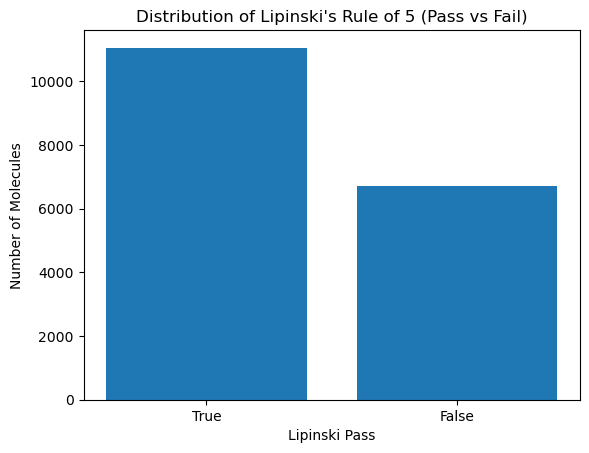

In [ ]:
# Count distribution
pass_count = df['Lipinski_Pass'].value_counts()
labels = df_clean['Lipinski_Pass'].values
class_counts = Counter(labels)
print(class_counts)

# Plot distribution
plt.bar(pass_count.index.astype(str), pass_count.values)
plt.xlabel("Lipinski Pass")
plt.ylabel("Number of Molecules")
plt.title("Distribution of Lipinski's Rule of 5 (Pass vs Fail)")
plt.show()

In [9]:
df.shape

(17784, 51)

In [10]:
df=df.drop_duplicates()

In [11]:
df.shape

(17784, 51)

### 2. Convert SMILES to PyTorch Geometric Data Objects

In [12]:
# atom feature extraction

def atom_features(atom):
    return torch.tensor([
        atom.GetAtomicNum(),              # atomic number
        atom.GetDegree(),                 # number of directly bonded neighbors
        atom.GetFormalCharge(),           # charge
        atom.GetHybridization().real,     # hybridization (sp, sp2, etc.)
        int(atom.GetIsAromatic())         # is aromatic?
    ], dtype=torch.float)

In [13]:
# SMILES → PyG Graph Conversion
def mol_to_graph(smiles, label):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        # Node features
        x = torch.stack([atom_features(atom) for atom in mol.GetAtoms()])

        # Bonds (edges)
        edge_index = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_index += [[i, j], [j, i]]  # undirected

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

        # Label
        y = torch.tensor([int(label)], dtype=torch.float)

        return Data(x=x, edge_index=edge_index, y=y)

    except:
        return None  # Skip if conversion fails

In [14]:
# applying to data
graph_list = []

for i, row in df_clean.iterrows():
    smiles = row['Ligand SMILES']
    label = row['Lipinski_Pass']
    graph = mol_to_graph(smiles, label)
    if graph:
        graph_list.append(graph)

print(f" Successfully created {len(graph_list)} graph data objects.")

 Successfully created 17773 graph data objects.


In [15]:
for i, data in enumerate(graph_list[:3]):  # Show first 3 graphs
    print(f"\n--- Molecule {i+1} ---")
    print(data)


--- Molecule 1 ---
Data(x=[43, 5], edge_index=[2, 90], y=[1])

--- Molecule 2 ---
Data(x=[44, 5], edge_index=[2, 92], y=[1])

--- Molecule 3 ---
Data(x=[41, 5], edge_index=[2, 84], y=[1])


x=[43, 5]: 43 atoms, 5 features per atom

edge_index=[2, 90]: 45 bonds (90 undirected edges)

y=[1]: Lipinski Pass = True


In [16]:
print(graph_list[0].edge_index)  # Each column is a [source, target] bond

tensor([[ 0,  1,  1,  2,  2,  3,  3,  4,  3,  5,  5,  6,  6,  7,  7,  8,  8,  9,
          9, 10, 10, 11, 11, 12, 12, 13, 13, 14,  7, 15, 15, 16, 16, 17, 16, 18,
         18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 23, 25, 25, 26, 18, 27,
         27, 28, 28, 29, 28, 30, 30, 31, 31, 32, 32, 33, 32, 34, 34, 35, 35, 36,
         36, 37, 36, 38, 38, 39, 30, 40, 40, 41, 40, 42, 13,  9, 26, 20, 39, 34],
        [ 1,  0,  2,  1,  3,  2,  4,  3,  5,  3,  6,  5,  7,  6,  8,  7,  9,  8,
         10,  9, 11, 10, 12, 11, 13, 12, 14, 13, 15,  7, 16, 15, 17, 16, 18, 16,
         19, 18, 20, 19, 21, 20, 22, 21, 23, 22, 24, 23, 25, 23, 26, 25, 27, 18,
         28, 27, 29, 28, 30, 28, 31, 30, 32, 31, 33, 32, 34, 32, 35, 34, 36, 35,
         37, 36, 38, 36, 39, 38, 40, 30, 41, 40, 42, 40,  9, 13, 20, 26, 34, 39]])


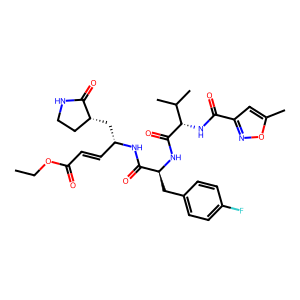

In [17]:
# visualize with rdkit

mol = Chem.MolFromSmiles(df_clean.iloc[0]['Ligand SMILES'])
Draw.MolToImage(mol)

### 3. Dataset Preparation & Splitting

In [18]:
# Split dataset into 80% train, 10% val, 10% test
train_graphs, temp_graphs = train_test_split(graph_list, test_size=0.2, random_state=42)
val_graphs, test_graphs = train_test_split(temp_graphs, test_size=0.5, random_state=42)

# Create data loaders
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=32, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

In [ ]:
# Simple GCN Model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin = nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # Graph-level pooling
        x = self.lin(x)
        return torch.sigmoid(x).view(-1) # Binary classification
    
# The input_dim is 5 (as we used 5 atom features per node)

### 4. GCN simple Model Training

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN(input_dim=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()  # Binary Cross Entropy

In [21]:
train_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []

def train():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [22]:
def evaluate(loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            preds = (out > 0.5).float().cpu()
            labels = batch.y.cpu()
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    return accuracy, precision, recall, f1


In [23]:
for epoch in range(1, 21):
    loss = train()
    acc, prec, rec, f1 = evaluate(val_loader)

    train_losses.append(loss)
    val_accuracies.append(acc)
    val_precisions.append(prec)
    val_recalls.append(rec)
    val_f1s.append(f1)

    print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Acc: {acc:.4f} | P: {prec:.4f} | R: {rec:.4f} | F1: {f1:.4f}")

Epoch 01 | Loss: 0.6614 | Acc: 0.6320 | P: 0.6299 | R: 1.0000 | F1: 0.7729
Epoch 02 | Loss: 0.6503 | Acc: 0.6207 | P: 0.6290 | R: 0.9614 | F1: 0.7605
Epoch 03 | Loss: 0.6477 | Acc: 0.6297 | P: 0.6290 | R: 0.9964 | F1: 0.7712
Epoch 04 | Loss: 0.6487 | Acc: 0.6230 | P: 0.6268 | R: 0.9838 | F1: 0.7657
Epoch 05 | Loss: 0.6471 | Acc: 0.6320 | P: 0.6377 | R: 0.9551 | F1: 0.7647
Epoch 06 | Loss: 0.6466 | Acc: 0.6230 | P: 0.6307 | R: 0.9605 | F1: 0.7614
Epoch 07 | Loss: 0.6461 | Acc: 0.6359 | P: 0.6499 | R: 0.9075 | F1: 0.7574
Epoch 08 | Loss: 0.6453 | Acc: 0.6303 | P: 0.6407 | R: 0.9326 | F1: 0.7596
Epoch 09 | Loss: 0.6451 | Acc: 0.6230 | P: 0.6310 | R: 0.9587 | F1: 0.7611
Epoch 10 | Loss: 0.6448 | Acc: 0.6331 | P: 0.6410 | R: 0.9416 | F1: 0.7627
Epoch 11 | Loss: 0.6448 | Acc: 0.6359 | P: 0.6422 | R: 0.9452 | F1: 0.7648
Epoch 12 | Loss: 0.6438 | Acc: 0.6376 | P: 0.6447 | R: 0.9389 | F1: 0.7644
Epoch 13 | Loss: 0.6438 | Acc: 0.6337 | P: 0.6442 | R: 0.9272 | F1: 0.7602
Epoch 14 | Loss: 0.6434 |

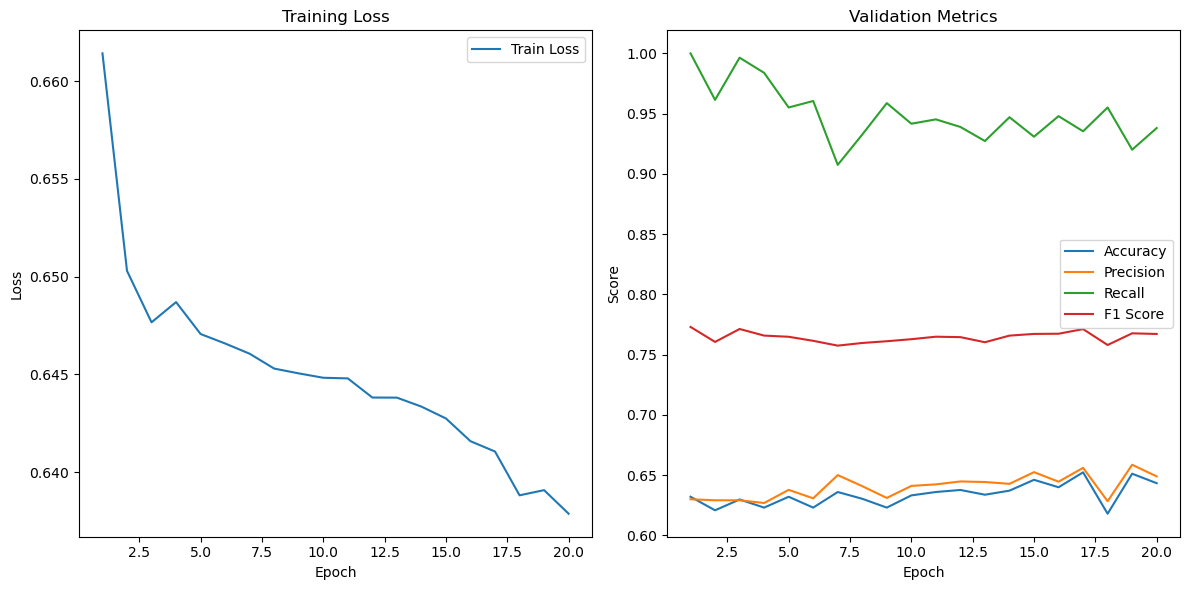

In [24]:
epochs = range(1, 21)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Accuracy')
plt.plot(epochs, val_precisions, label='Precision')
plt.plot(epochs, val_recalls, label='Recall')
plt.plot(epochs, val_f1s, label='F1 Score')
plt.title("Validation Metrics")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()


The loss consistently decreases across 20 epochs — a positive sign that the model is learning.

However, the loss reduction is very gradual (from ~0.655 to ~0.635), indicating possible underfitting.

Recall is consistently high (often ≥ 0.9), meaning the model is good at identifying positive Lipinski Passes.

Precision is relatively lower (~0.63–0.64), which could mean the model also predicts some false positives.

F1 Score remains around 0.76, showing balanced but not outstanding performance.

Accuracy hovers around ~0.63.

### 4. GCN Model with Weighted Loss (for imbalance)

In [ ]:
# Re-initialize model, optimizer, and use BCEWithLogitsLoss (no sigmoid in forward!)
class GCN_Weighted(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(GCN_Weighted, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin = nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x).view(-1)  # no sigmoid here

# Compute class weights from training set
all_train_labels = torch.cat([batch.y for batch in train_loader])
pos_weight = torch.tensor((all_train_labels == 0).sum() / (all_train_labels == 1).sum(), dtype=torch.float)

# Prepare model, optimizer, and weighted loss
model_w = GCN_Weighted(input_dim=5).to(device)
optimizer_w = torch.optim.Adam(model_w.parameters(), lr=0.001)
criterion_w = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

# Training + evaluation logic
def train_w():
    model_w.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer_w.zero_grad()
        out = model_w(batch.x, batch.edge_index, batch.batch)
        loss = criterion_w(out, batch.y)
        loss.backward()
        optimizer_w.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate_w(loader):
    model_w.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            logits = model_w(batch.x, batch.edge_index, batch.batch)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float().cpu()
            labels = batch.y.cpu()
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())

    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    return accuracy, precision, recall, f1

# Train and print results
train_losses_w = []
val_accuracies_w = []
val_precisions_w = []
val_recalls_w = []
val_f1s_w = []

for epoch in range(1, 21):
    loss = train_w()
    acc, prec, rec, f1 = evaluate_w(val_loader)

    train_losses_w.append(loss)
    val_accuracies_w.append(acc)
    val_precisions_w.append(prec)
    val_recalls_w.append(rec)
    val_f1s_w.append(f1)

    print(f"[Weighted] Epoch {epoch:02d} | Loss: {loss:.4f} | Acc: {acc:.4f} | P: {prec:.4f} | R: {rec:.4f} | F1: {f1:.4f}")


/var/folders/pc/65k66fpd65940gkc6sklbn3m0000gn/T/ipykernel_48315/3683448706.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight = torch.tensor((all_train_labels == 0).sum() / (all_train_labels == 1).sum(), dtype=torch.float)


[Weighted] Epoch 01 | Loss: 0.5182 | Acc: 0.5813 | P: 0.6519 | R: 0.7116 | F1: 0.6804
[Weighted] Epoch 02 | Loss: 0.5116 | Acc: 0.5155 | P: 0.7368 | R: 0.3522 | F1: 0.4766
[Weighted] Epoch 03 | Loss: 0.5110 | Acc: 0.5988 | P: 0.6767 | R: 0.6882 | F1: 0.6824
[Weighted] Epoch 04 | Loss: 0.5099 | Acc: 0.5931 | P: 0.6690 | R: 0.6936 | F1: 0.6811
[Weighted] Epoch 05 | Loss: 0.5105 | Acc: 0.5948 | P: 0.6814 | R: 0.6631 | F1: 0.6721
[Weighted] Epoch 06 | Loss: 0.5097 | Acc: 0.5554 | P: 0.7436 | R: 0.4429 | F1: 0.5552
[Weighted] Epoch 07 | Loss: 0.5090 | Acc: 0.5785 | P: 0.7073 | R: 0.5580 | F1: 0.6238
[Weighted] Epoch 08 | Loss: 0.5087 | Acc: 0.5898 | P: 0.6705 | R: 0.6783 | F1: 0.6744
[Weighted] Epoch 09 | Loss: 0.5082 | Acc: 0.5931 | P: 0.6812 | R: 0.6586 | F1: 0.6697
[Weighted] Epoch 10 | Loss: 0.5080 | Acc: 0.5830 | P: 0.7071 | R: 0.5705 | F1: 0.6315
[Weighted] Epoch 11 | Loss: 0.5080 | Acc: 0.5836 | P: 0.6961 | R: 0.5948 | F1: 0.6415
[Weighted] Epoch 12 | Loss: 0.5071 | Acc: 0.5982 | P: 

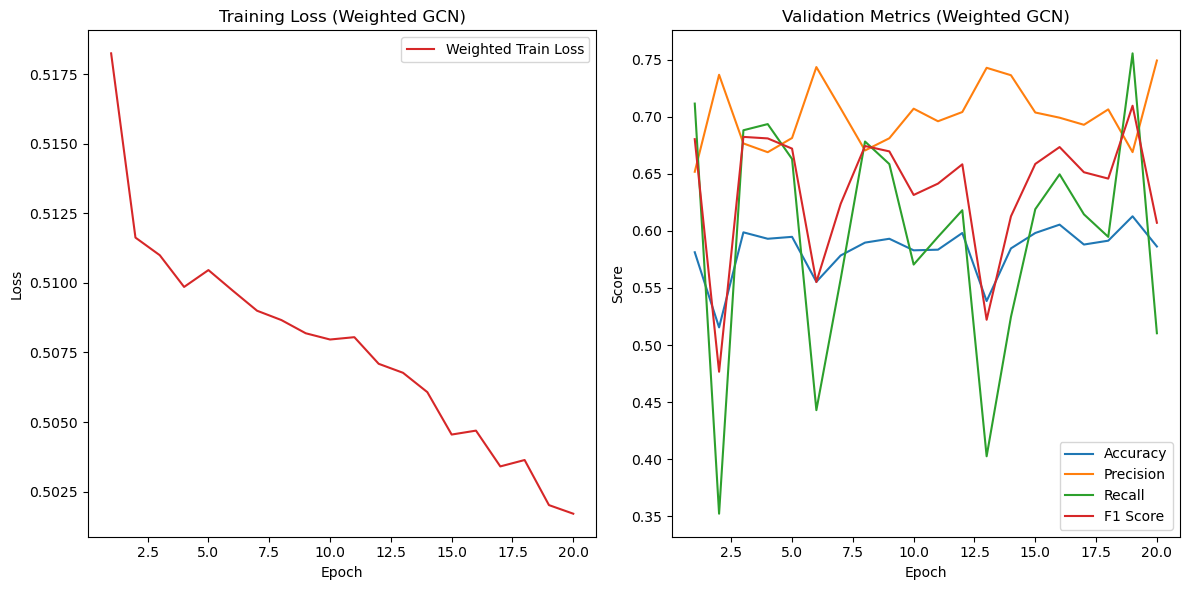

In [26]:
# Plotting for Weighted GCN
epochs = range(1, 21)

plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_w, label='Weighted Train Loss', color='tab:red')
plt.title("Training Loss (Weighted GCN)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot validation metrics
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies_w, label='Accuracy')
plt.plot(epochs, val_precisions_w, label='Precision')
plt.plot(epochs, val_recalls_w, label='Recall')
plt.plot(epochs, val_f1s_w, label='F1 Score')
plt.title("Validation Metrics (Weighted GCN)")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()

plt.tight_layout()
plt.show()


Vanilla GCN: Strong recall, poor precision → model is biased toward the positive class.

Weighted GCN: Enforces balance; precision improves, recall drops slightly → better for real-world deployment if both types of errors matter.

### 5. GAT architecture

In [27]:
# Define GAT model
class GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, heads=2):
        super(GAT, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=1)
        self.lin = nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index, batch):
        x = F.elu(self.gat1(x, edge_index))
        x = F.elu(self.gat2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return torch.sigmoid(x).view(-1)

# Initialize
gat_model = GAT(input_dim=5).to(device)
gat_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.001)
gat_criterion = nn.BCELoss()

# Tracking
gat_train_losses = []
gat_val_accuracies = []
gat_val_precisions = []
gat_val_recalls = []
gat_val_f1s = []

def train_gat():
    gat_model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        gat_optimizer.zero_grad()
        out = gat_model(batch.x, batch.edge_index, batch.batch)
        loss = gat_criterion(out, batch.y)
        loss.backward()
        gat_optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate_gat(loader):
    gat_model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = gat_model(batch.x, batch.edge_index, batch.batch)
            preds = (out > 0.5).float().cpu()
            labels = batch.y.cpu()
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    return accuracy, precision, recall, f1

# Training Loop
for epoch in range(1, 21):
    loss = train_gat()
    acc, prec, rec, f1 = evaluate_gat(val_loader)
    gat_train_losses.append(loss)
    gat_val_accuracies.append(acc)
    gat_val_precisions.append(prec)
    gat_val_recalls.append(rec)
    gat_val_f1s.append(f1)
    print(f"[GAT] Epoch {epoch:02d} | Loss: {loss:.4f} | Acc: {acc:.4f} | P: {prec:.4f} | R: {rec:.4f} | F1: {f1:.4f}")

[GAT] Epoch 01 | Loss: 0.6543 | Acc: 0.6145 | P: 0.6246 | R: 0.9641 | F1: 0.7580
[GAT] Epoch 02 | Loss: 0.6458 | Acc: 0.6021 | P: 0.6475 | R: 0.8005 | F1: 0.7160
[GAT] Epoch 03 | Loss: 0.6395 | Acc: 0.6246 | P: 0.6334 | R: 0.9515 | F1: 0.7605
[GAT] Epoch 04 | Loss: 0.6364 | Acc: 0.6033 | P: 0.6443 | R: 0.8185 | F1: 0.7210
[GAT] Epoch 05 | Loss: 0.6345 | Acc: 0.6303 | P: 0.6404 | R: 0.9344 | F1: 0.7600
[GAT] Epoch 06 | Loss: 0.6327 | Acc: 0.6348 | P: 0.6446 | R: 0.9290 | F1: 0.7611
[GAT] Epoch 07 | Loss: 0.6296 | Acc: 0.6263 | P: 0.6413 | R: 0.9155 | F1: 0.7543
[GAT] Epoch 08 | Loss: 0.6269 | Acc: 0.6460 | P: 0.6653 | R: 0.8751 | F1: 0.7559
[GAT] Epoch 09 | Loss: 0.6258 | Acc: 0.6286 | P: 0.6408 | R: 0.9263 | F1: 0.7575
[GAT] Epoch 10 | Loss: 0.6220 | Acc: 0.6590 | P: 0.7007 | R: 0.7951 | F1: 0.7449
[GAT] Epoch 11 | Loss: 0.6233 | Acc: 0.6280 | P: 0.6352 | R: 0.9542 | F1: 0.7627
[GAT] Epoch 12 | Loss: 0.6197 | Acc: 0.6325 | P: 0.6458 | R: 0.9155 | F1: 0.7573
[GAT] Epoch 13 | Loss: 0.619

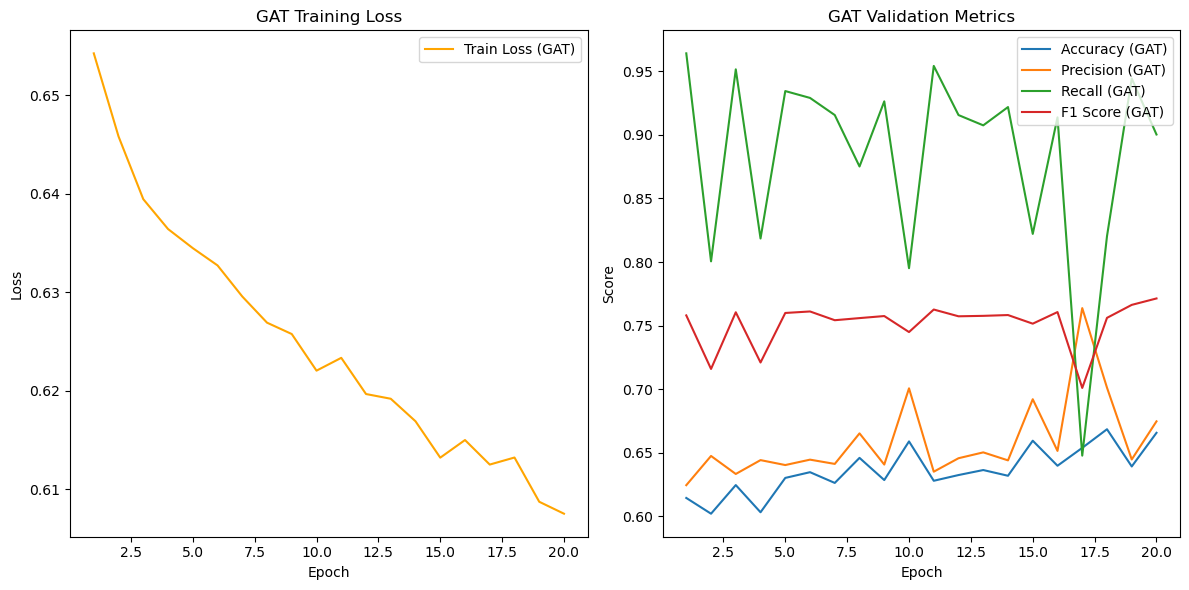

In [28]:
# Plot GAT metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, 21), gat_train_losses, label='Train Loss (GAT)', color='orange')
plt.title("GAT Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 21), gat_val_accuracies, label='Accuracy (GAT)')
plt.plot(range(1, 21), gat_val_precisions, label='Precision (GAT)')
plt.plot(range(1, 21), gat_val_recalls, label='Recall (GAT)')
plt.plot(range(1, 21), gat_val_f1s, label='F1 Score (GAT)')
plt.title("GAT Validation Metrics")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()

GAT outperforms both vanilla and weighted GCN in:

F1 Score ( from 0.7683 to 0.7768)

Accuracy ( from 64.32% to 68.99%)

Precision and recall are also more balanced across epochs.

GAT performd better because

1. Molecules are heterogeneous — not all atoms (nodes) contribute equally to drug-likeness.

2. GAT learned to focus more on important atoms or substructures within the molecule.

3. The adaptive attention mechanism gave better feature aggregation for predicting Lipinski pass/fail.



### 6. Graph Isomorphism Network Architecture
Graph Isomorphism Network (GIN) is one of the most expressive GNN architectures — it's theoretically as powerful as the Weisfeiler-Lehman graph isomorphism test. That makes it particularly well-suited for molecular property prediction tasks.

In [30]:
class GIN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(GIN, self).__init__()
        nn1 = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
        nn2 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
        
        self.conv1 = GINConv(nn1)
        self.conv2 = GINConv(nn2)
        self.lin = nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return torch.sigmoid(self.lin(x)).view(-1)

# Initialize model, optimizer, loss
model_gin = GIN(input_dim=5).to(device)
optimizer_gin = torch.optim.Adam(model_gin.parameters(), lr=0.001)
criterion_gin = nn.BCELoss()

# Training and evaluation for GIN
train_losses_gin = []
val_accuracies_gin = []
val_precisions_gin = []
val_recalls_gin = []
val_f1s_gin = []

def train_gin():
    model_gin.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer_gin.zero_grad()
        out = model_gin(batch.x, batch.edge_index, batch.batch)
        loss = criterion_gin(out, batch.y)
        loss.backward()
        optimizer_gin.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate_gin(loader):
    model_gin.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model_gin(batch.x, batch.edge_index, batch.batch)
            preds = (out > 0.5).float().cpu()
            labels = batch.y.cpu()
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    return accuracy, precision, recall, f1

# Run GIN training
for epoch in range(1, 21):
    loss = train_gin()
    acc, prec, rec, f1 = evaluate_gin(val_loader)

    train_losses_gin.append(loss)
    val_accuracies_gin.append(acc)
    val_precisions_gin.append(prec)
    val_recalls_gin.append(rec)
    val_f1s_gin.append(f1)

    print(f"[GIN] Epoch {epoch:02d} | Loss: {loss:.4f} | Acc: {acc:.4f} | P: {prec:.4f} | R: {rec:.4f} | F1: {f1:.4f}")


[GIN] Epoch 01 | Loss: 0.6558 | Acc: 0.6320 | P: 0.6299 | R: 1.0000 | F1: 0.7729
[GIN] Epoch 02 | Loss: 0.6509 | Acc: 0.6207 | P: 0.6295 | R: 0.9587 | F1: 0.7600
[GIN] Epoch 03 | Loss: 0.6486 | Acc: 0.6230 | P: 0.6389 | R: 0.9155 | F1: 0.7526
[GIN] Epoch 04 | Loss: 0.6468 | Acc: 0.6269 | P: 0.6408 | R: 0.9200 | F1: 0.7554
[GIN] Epoch 05 | Loss: 0.6451 | Acc: 0.6258 | P: 0.6514 | R: 0.8661 | F1: 0.7435
[GIN] Epoch 06 | Loss: 0.6435 | Acc: 0.6258 | P: 0.6659 | R: 0.8077 | F1: 0.7300
[GIN] Epoch 07 | Loss: 0.6353 | Acc: 0.6252 | P: 0.6293 | R: 0.9775 | F1: 0.7657
[GIN] Epoch 08 | Loss: 0.6207 | Acc: 0.6466 | P: 0.6453 | R: 0.9677 | F1: 0.7743
[GIN] Epoch 09 | Loss: 0.6017 | Acc: 0.6635 | P: 0.6713 | R: 0.9066 | F1: 0.7714
[GIN] Epoch 10 | Loss: 0.5883 | Acc: 0.6894 | P: 0.7073 | R: 0.8598 | F1: 0.7762
[GIN] Epoch 11 | Loss: 0.5760 | Acc: 0.6978 | P: 0.7202 | R: 0.8464 | F1: 0.7782
[GIN] Epoch 12 | Loss: 0.5622 | Acc: 0.6989 | P: 0.7637 | R: 0.7520 | F1: 0.7578
[GIN] Epoch 13 | Loss: 0.553

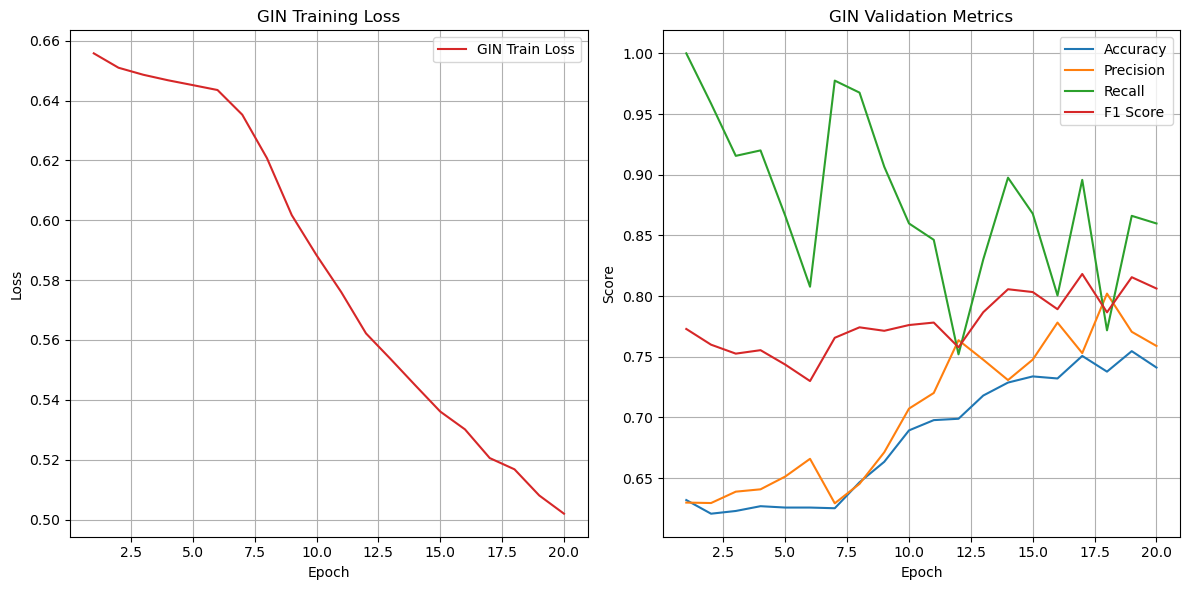

In [33]:
epochs = range(1, len(train_losses_gin) + 1)

plt.figure(figsize=(12, 6))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_gin, label='GIN Train Loss', color='tab:red')
plt.title("GIN Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot Validation Metrics
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies_gin, label='Accuracy')
plt.plot(epochs, val_precisions_gin, label='Precision')
plt.plot(epochs, val_recalls_gin, label='Recall')
plt.plot(epochs, val_f1s_gin, label='F1 Score')
plt.title("GIN Validation Metrics")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 7. Final loss and F1 score comparison over all models

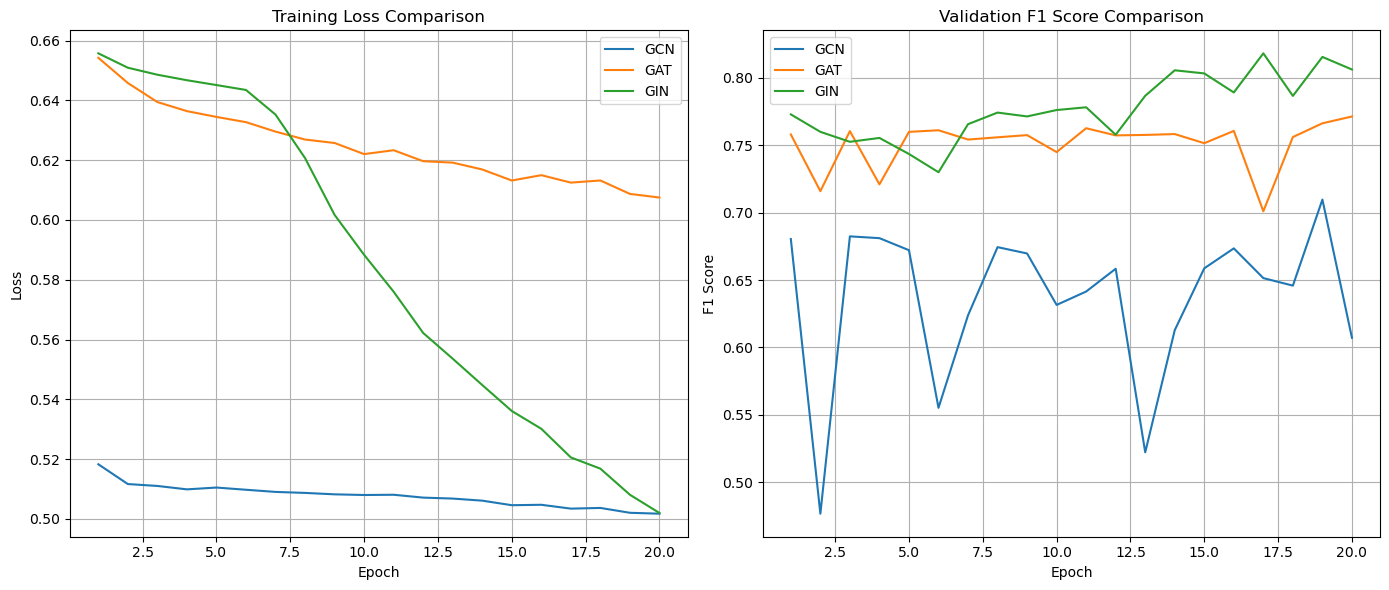

In [36]:
epochs = range(1, 21)  # adjust if using more epochs

plt.figure(figsize=(14, 6))

# Subplot 1: Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_w, label='GCN')
plt.plot(epochs, gat_train_losses, label='GAT')
plt.plot(epochs, train_losses_gin, label='GIN')
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Subplot 2: F1 Score
plt.subplot(1, 2, 2)
plt.plot(epochs, val_f1s_w, label='GCN')
plt.plot(epochs, gat_val_f1s, label='GAT')
plt.plot(epochs, val_f1s_gin, label='GIN')
plt.title("Validation F1 Score Comparison")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

1. GIN is designed to be as powerful as the Weisfeiler-Lehman test for graph isomorphism. This allows it to better differentiate subtle graph structures, which is crucial for molecule property prediction.
2. Faster Convergence: GIN learns faster as shown by its sharper loss curve. This is likely due to stronger gradient flow and more informative neighborhood aggregation.
3. Less Overfitting: Even with improved performance, GIN’s F1 remains stable — indicating it balances learning and generalization well.
4. Property Alignment: Lipinski’s rule is tied to structure (donors, acceptors, MW), and GIN can model such node-level and edge-level features more effectively through its MLP-based update rule